In [1]:
import pandas as pd
from RoutePlanner.CellGrid import CellGrid
from RoutePlanner.IO import LoadIcePoints, LoadCurrentPoints
from RoutePlanner.Optimisation import TravelTime

In [2]:
OptInfo = {}
OptInfo['Bounds Longitude']     = [230,360]
OptInfo['Bounds Latitude']      = [-80,-40]
OptInfo['Grid Spacing (dx,dy)'] = [5,2.5]
OptInfo['Start Time']           = '2017-05-01'
OptInfo['End Time']             = '2017-06-01'
OptInfo['WayPoints']            = pd.read_csv('../../resources/WayPoints_TestExample3.csv') 
OptInfo['MaxIceExtent']         = 0.8
OptInfo['Zero Currents']        = False
OptInfo['VariableSpeed']        = False
OptInfo['Time Unit']            = 'days'
OptInfo['VehicleInfo']          = {}
OptInfo['VehicleInfo']['Speed'] = 26.3
OptInfo['VehicleInfo']['Unit']  = 'km/hr'
OptInfo['Start Waypoints']      = None

In [37]:
icePoints     = LoadIcePoints('../../Data/bsose_i122_2013to2017_1day_SeaIceArea.nc',OptInfo['Start Time'],OptInfo['End Time'])
currentPoints = LoadCurrentPoints('../../Data/SOSE_surface_velocity_6yearMean_2005-2010.nc')

cellGrid = CellGrid(OptInfo)
cellGrid.addIcePoints(icePoints)
cellGrid.addCurrentPoints(currentPoints)
cellGrid.recursiveSplit(2)

In [39]:
Org = [303.5,-65.5]

In [96]:


def RandomPointSurface(cell,type):
    # Random coordinates [b,a) uniform distributed
    coordy = (cell.height) *  np.random.random_sample((1,)) + cell.lat # generate random y
    coordx = (cell.width) *  np.random.random_sample((1,)) + cell.long # generate random x
    if type == 'bottom':
        coordy = cell.lat
    if type == 'top':
        coordy = cell.lat + cell.height
    if type == 'left':
        coordx = cell.long
    if type == 'right':
        coordx = cell.long + cell.width
    return coordx,coordy

def CornerCells(Cell_s,Cells):
    cornerCells = []
    Cps = []   
    for cell in Cells:
        a = np.array(Cell_s.getBounds())
        b = np.array(cell.getBounds())
        df_x = (cell.long+cell.width/2) -  (Cell_s.long+Cell_s.width/2)
        df_y = (cell.lat+cell.height/2) -  (Cell_s.lat+Cell_s.height/2)
        cornerBool = (abs(df_x) >= Cell_s.width/2) and (abs(df_y) >= Cell_s.height/2) and (abs(df_x) >= cell.width/2) & (abs(df_y) >= cell.height/2)
        c = np.array([x for x in set([tuple(x) for x in a]) & set([tuple(x) for x in b])])
        if (c.shape[0] == 1) & (cornerBool):
            cornerCells.append(cell)
            Cps.append(c)        
    return cornerCells,Cps


Cell_s     = cellGrid.getCellBox(Org[1],Org[0])
Cells,indx = cellGrid.getNeightbours(Cell_s)
Cells,Cps = CornerCells(Cell_s,Cells)

In [190]:
rndCell_idx = random.choice(range(len(Cells)))
rndCell = Cells[rndCell_idx]

In [191]:
Spx,Spy = RandomPointSurface(Cell_s,'bottom')
Npx,Npy = RandomPointSurface(rndCell,'top')

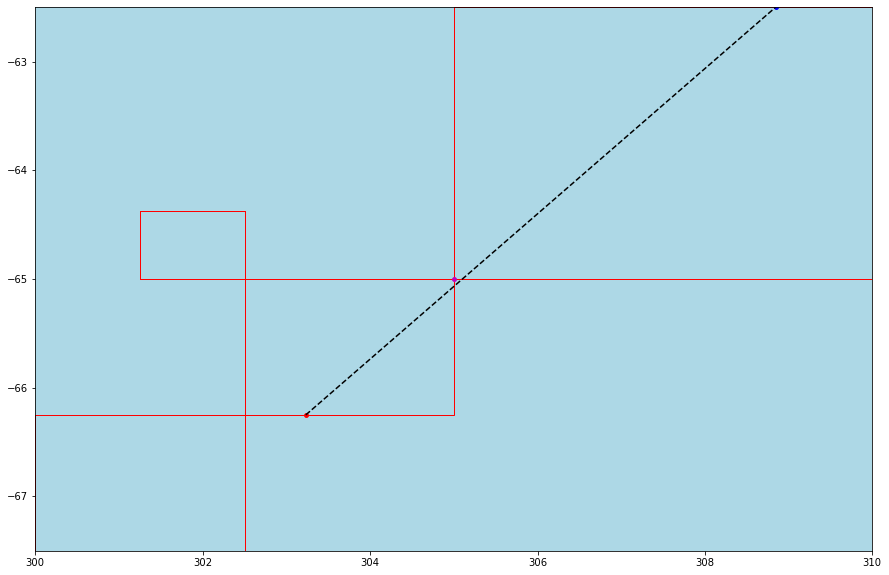

In [192]:
import matplotlib.pylab as plt
from matplotlib.patches import Polygon
import numpy as np
import random

fig,ax = plt.subplots(1,1,figsize=(15,10))
fig.patch.set_facecolor('white')
ax.set_facecolor('lightblue')
ax.patch.set_alpha(1.0)
bounds=[]
ax.add_patch(Cell_s.getHighlight())
for cellBox in Cells:
    bounds.append([cellBox.long,cellBox.lat])
    bounds.append([cellBox.long+cellBox.width,cellBox.lat+cellBox.height])
    ax.add_patch(cellBox.getHighlight())
bounds = np.array(bounds)
ax.set_xlim([bounds[:,0].min(),bounds[:,0].max()])
ax.set_ylim([bounds[:,1].min(),bounds[:,1].max()])

ax.scatter(Spx,Spy,15,'r')
ax.scatter(Npx,Npy,15,'b')
ax.plot([Spx,Npx],[Spy,Npy],'--k')

ax.scatter(Cps[rndCell_idx][:,0],Cps[rndCell_idx][:,1],15,'m')


In [193]:
import math
def sign(x):
    s = math.copysign(1, x)
    return s   

debugging = 1 


df_x = (rndCell.long+rndCell.width/2) -  (Cell_s.long+Cell_s.width/2)
df_y = abs((rndCell.lat+rndCell.height/2) -  (Cell_s.lat+Cell_s.height/2))


# Defining the lat/long of the points
Xs = Spx[0]
Ys = Spy
Xc = Cps[rndCell_idx][:,0]
Yc = Cps[rndCell_idx][:,1]
Xe = Npx[0]
Ye = Npy

# Correcting corner point
a = np.array(Cell_s.getBounds())
b = np.array(rndCell.getBounds())
c = np.array([x for x in set([tuple(x) for x in a]) & set([tuple(x) for x in b])])
Xc=c[0,0]; Yc=c[0,1]

# # Determine the intersection point on the edge where end_p is assuming a straight path through corner
Y_line = ((Yc-Ys)/(Xc-Xs))*(Xe-Xs) + Ys

# Determining the cells in contact with the corner point
CornerCells = []
neighbours,neighbours_idx = cellGrid.getNeightbours(Cell_s)
for idx in neighbours_idx:
    cell = cellGrid.cellBoxes[idx]
    if ((((np.array(cell.getBounds()) - np.array([Xc,Yc])[None,:])**2).sum(axis=1)) == 0).any() and (cell.containsPoint(Ye,Xe) != True):
        CornerCells.append([idx,cell.long+cell.width/2,cell.lat+cell.height/2]) 
CornerCells = np.array(CornerCells)

# ====== Determining the crossing points & their corresponding index
# Case 1 - Top Right
if (sign(df_x) == 1) and (sign(df_y) == 1):
    if debugging>=1:
        print('--Corner Case TopRight: Xs=[{:.2f},{:.2f}]; Xc=[{:.2f},{:.2f}]; Xe=[{:.2f},{:.2f}];'.format(Xs,Ys,Xc,Yc,Xe,Ye))   
        print('----- df_x={}, df_y={}'.format(df_x,df_y))
        print('---- Ye={}; Y_line={}'.format(Ye,Y_line))
        print('-- Corner Cells={}'.format(CornerCells))

    if Ye >= Y_line:
        idx           = int(CornerCells[CornerCells[:,1].argmin(),0])
        cell          = cellGrid.cellBoxes[idx]


        
        Crp1_x,Crp1_y = cell.long+cell.width/2, cell.lat
        Crp2_x,Crp2_y = cell.long+cell.width, cell.lat+cell.height/2
    elif Ye < Y_line:
        idx           = int(CornerCells[CornerCells[:,1].argmax(),0])
        cell          = cellGrid.cellBoxes[idx]
        Crp1_x,Crp1_y = cell.long, cell.lat+cell.height/2
        Crp2_x,Crp2_y = cell.long+cell.width/2, cell.lat+cell.height

# Case -3 - Top Left
if (np.sign(df_x) == -1) and (np.sign(df_y) == 1):
    if debugging>=1:
        print('--Corner Case TopLeft: Xs=[{:.2f},{:.2f}]; Xc=[{:.2f},{:.2f}]; Xe=[{:.2f},{:.2f}];'.format(Xs,Ys,Xc,Yc,Xe,Ye))   
        print('----- df_x={}, df_y={}'.format(df_x,df_y))
        print('---- Ye={}; Y_line={}'.format(Ye,Y_line))
        print('-- Corner Cells={}'.format(CornerCells)) 

    if Ye <= Y_line:
        idx  = int(CornerCells[CornerCells[:,1].argmin(),0])
        cell = cellGrid.cellBoxes[idx]
        Crp1_x,Crp1_y = cell.long + cell.width, cell.lat+cell.height/2
        Crp2_x,Crp2_y = cell.long+cell.width/2, cell.lat+cell.height

    elif Ye > Y_line:
        idx  = int(CornerCells[CornerCells[:,1].argmax(),0])
        cell = cellGrid.cellBoxes[idx]
        Crp1_x,Crp1_y = cell.long+cell.width/2, cell.lat 
        Crp2_x,Crp2_y = cell.long, cell.lat+cell.height/2

# Case -1 - Bottom Left
if (np.sign(df_x) == -1) and (np.sign(df_y) == -1):
    if debugging>=1:
        print('--Corner Case BottomLeft: Xs=[{:.2f},{:.2f}]; Xc=[{:.2f},{:.2f}]; Xe=[{:.2f},{:.2f}];'.format(Xs,Ys,Xc,Yc,Xe,Ye))   
        print('----- df_x={}, df_y={}'.format(df_x,df_y)) 
        print('---- Ye={}; Y_line={}'.format(Ye,Y_line))
        print('-- Corner Cells={}'.format(CornerCells))

    if Ye >= Y_line:
        idx  = int(CornerCells[CornerCells[:,1].argmin(),0])
        cell = cellGrid.cellBoxes[idx]
        Crp1_x,Crp1_y = cell.long+cell.width, cell.lat+cell.height/2 
        Crp2_x,Crp2_y = cell.long+cell.width/2, cell.lat 
    elif Ye < Y_line:
        idx  = int(CornerCells[CornerCells[:,1].argmax(),0])
        cell = cellGrid.cellBoxes[idx]
        Crp1_x,Crp1_y = cell.long + cell.width, cell.lat+cell.height/2
        Crp2_x,Crp2_y = cell.long + cell.width/2, cell.lat

# Case 3 - Bottom Right
if (np.sign(df_x) == 1) and (np.sign(df_y) == -1):
    if debugging>=1:
        print('--Corner Case BottomRight: Xs=[{:.2f},{:.2f}]; Xc=[{:.2f},{:.2f}]; Xe=[{:.2f},{:.2f}];'.format(Xs,Ys,Xc,Yc,Xe,Ye))   
        print('----- df_x={}, df_y={}'.format(df_x,df_y))
        print('---- Ye={}; Y_line={}'.format(Ye,Y_line))
        print('-- Corner Cells={}'.format(CornerCells)) 

    if Ye >= Y_line:
        idx  = int(CornerCells[CornerCells[:,1].argmax(),0])
        cell = cellGrid.cellBoxes[idx]
        Crp1_x,Crp1_y = cell.long, cell.lat+cell.height/2
        Crp2_x,Crp2_y = cell.long+cell.width/2, cell.lat

    elif Ye < Y_line:
        idx  = int(CornerCells[CornerCells[:,1].argmin(),0])
        cell = cellGrid.cellBoxes[idx]
        Crp1_x,Crp1_y = cell.long + cell.width/2, cell.lat+cell.height
        Crp2_x,Crp2_y = cell.long + cell.width, cell.lat+cell.height/2


--Corner Case TopRight: Xs=[303.23,-66.25]; Xc=[305.00,-65.00]; Xe=[308.85,-62.50];
----- df_x=3.75, df_y=1.875
---- Ye=-62.5; Y_line=-62.282441732399064
-- Corner Cells=[[908.     307.5    -66.25  ]
 [850.     304.375  -64.6875]]


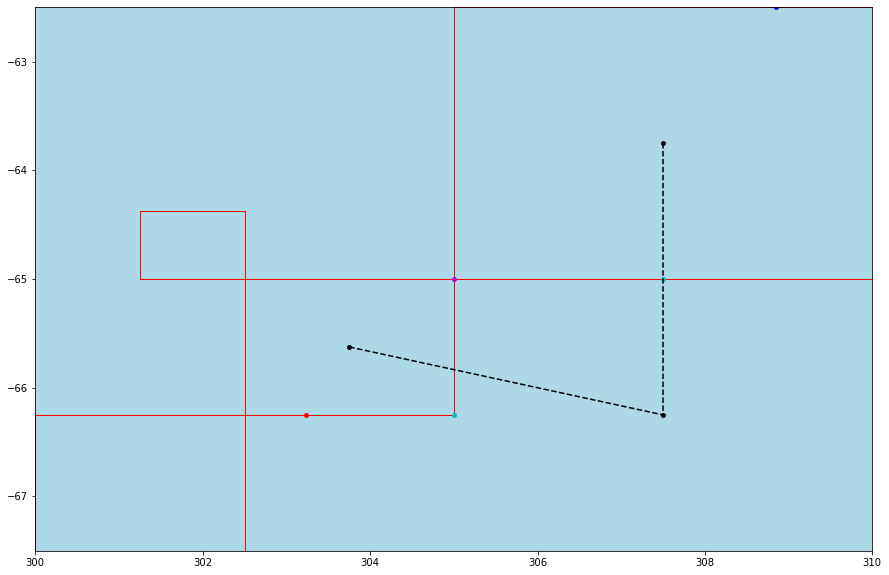

In [210]:
import matplotlib.pylab as plt
from matplotlib.patches import Polygon
import numpy as np
import random

fig,ax = plt.subplots(1,1,figsize=(15,10))
fig.patch.set_facecolor('white')
ax.set_facecolor('lightblue')
ax.patch.set_alpha(1.0)
bounds=[]
ax.add_patch(Cell_s.getHighlight())
for cellBox in Cells:
    bounds.append([cellBox.long,cellBox.lat])
    bounds.append([cellBox.long+cellBox.width,cellBox.lat+cellBox.height])
    ax.add_patch(cellBox.getHighlight())
bounds = np.array(bounds)
ax.set_xlim([bounds[:,0].min(),bounds[:,0].max()])
ax.set_ylim([bounds[:,1].min(),bounds[:,1].max()])


ax.scatter(Spx,Spy,15,'r')
ax.scatter(Npx,Npy,15,'b')
ax.scatter(Cps[rndCell_idx][:,0],Cps[rndCell_idx][:,1],15,'m')
ax.scatter(Crp1_x,Crp1_y,15,'c')
ax.scatter(Crp2_x,Crp2_y,15,'c')



CornerCell = [cell.long+cell.width/2,cell.lat+cell.height/2]
Box1_c     = [Cell_s.long+Cell_s.width/2,Cell_s.lat+Cell_s.height/2]
Box2_c     = [rndCell.long+rndCell.width/2,rndCell.lat+rndCell.height/2]

ax.scatter(CornerCell[0],CornerCell[1],15,'k')
ax.scatter(Box1_c[0],Box1_c[1],15,'k')
ax.scatter(Box2_c[0],Box2_c[1],15,'k')

ax.plot([Box1_c[0],CornerCell[0]],[Box1_c[1],CornerCell[1]],'--k')
ax.plot([Box2_c[0],CornerCell[0]],[Box2_c[1],CornerCell[1]],'--k')


In [122]:
def Intersection_BoxLine(Line,Cell_s,Cell_n,type):

    X1,Y1 = Cell_s.long+Cell_s.width/2,Cell_s.lat+Cell_s.height/2
    X2,Y2 = Cell_n.long+Cell_n.width/2,Cell_n.lat+Cell_n.height/2
    
    if type == 'right':
        X3,Y3 = Cell_s.long+Cell_s.width,Cell_s.lat
        X4,Y4 = Cell_s.long+Cell_s.width,Cell_s.lat+Cell_s.height
    
    D  = (X1-X2)*(Y3-Y4) - (Y1-Y2)*(X3-X4)
    Px = ((X1*Y2 - Y1*X2)*(X3-X4) - (X1-X2)*(X3*Y4-Y3*X4))/D
    Py = ((X1*Y2-Y1*X2)*(Y3-Y4)-(Y1-Y2)*(X3*Y4-Y3*X4))/D
    return Px,Py


-66.25

In [58]:
def Intersection_BoxLine(Cell_s,Cell_n,type,debugging=1):
    X1,Y1 = Cell_s.long+Cell_s.width/2,Cell_s.lat+Cell_s.height/2
    X2,Y2 = Cell_n.long+Cell_n.width/2,Cell_n.lat+Cell_n.height/2
    if type == 'right':
        X3,Y3 = Cell_s.long+Cell_s.width,Cell_s.lat
        X4,Y4 = Cell_s.long+Cell_s.width,Cell_s.lat+Cell_s.height
    if type == 'top':
        X3,Y3 = Cell_s.long,Cell_s.lat+Cell_s.height
        X4,Y4 = Cell_s.long+Cell_s.width,Cell_s.lat+Cell_s.height
    if type == 'left':
        X3,Y3 = Cell_s.long,Cell_s.lat
        X4,Y4 = Cell_s.long,Cell_s.lat+Cell_s.height
    if type == 'bottom':
        X3,Y3 = Cell_s.long,Cell_s.lat
        X4,Y4 = Cell_s.long+Cell_s.width,Cell_s.lat
    D  = (X1-X2)*(Y3-Y4) - (Y1-Y2)*(X3-X4)
    

    Px = ((X1*Y2 - Y1*X2)*(X3-X4) - (X1-X2)*(X3*Y4-Y3*X4))/D
    Py = ((X1*Y2-Y1*X2)*(Y3-Y4)-(Y1-Y2)*(X3*Y4-Y3*X4))/D

    if debugging > 0:
        print(D,Px,Py)
    return Px,Py





-0.16514867741462683

In [112]:
Xs

array([304.49042432])